In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from dataclasses import dataclass

In [2]:
%matplotlib widget
sns.set_theme(style="whitegrid")

### The Sphere AMM

In [3]:
@dataclass
class SphereAMM:
    n: int
    r: float

    def center(self):
        return np.full(self.n, self.r, dtype=float)

    def F(self, x):
        x = np.asarray(x, dtype=float)
        return np.sum((self.r - x)**2) - self.r**2

    def on_surface(self, x, tol=1e-10):
        return abs(self.F(x)) <= tol

    def equal_point(self):
        q_scalar = self.r * (1.0 - 1.0/np.sqrt(self.n))
        return np.full(self.n, q_scalar, dtype=float)
    
    def state_on_circle(self, theta):
        if self.n != 2:
            raise ValueError("state_on_circle(theta) is only for n=2.")
        c = self.center()
        return np.array([c[0] + self.r*np.cos(theta),
                         c[1] + self.r*np.sin(theta)], dtype=float)
    
    def price_ij(self, x, i, j):
        x = np.asarray(x, dtype=float)
        den = self.r - x[j]
        if abs(den) < 1e-15:
            return np.inf * np.sign(self.r - x[i])
        return (self.r - x[i]) / den



In [4]:
t = np.linspace(0, 2*np.pi, 800)
r0 = 1.0

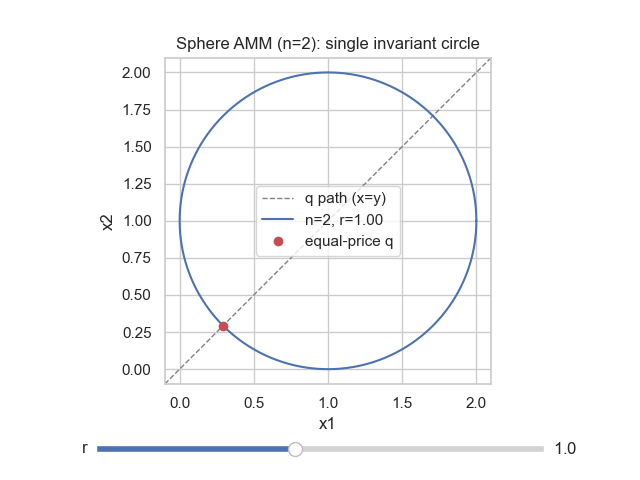

In [5]:
n = 2

amm = SphereAMM(n, r0)
cx, cy = amm.center()
x = cx + r0 * np.cos(t)
y = cy + r0 * np.sin(t)
q = amm.equal_point()

fig = plt.figure()
plt.subplots_adjust(bottom=0.2)
plt.axline((0, 0), slope=1, linestyle='--', linewidth=1.0, label="q path (x=y)", color='gray')
(line,) = plt.plot(x, y, label=f"n={n}, r={r0:.2f}")
(point,) = plt.plot([q[0]], [q[1]], 'ro', label="equal-price q")
plt.gca().set_aspect("equal", "box")
plt.xlabel("x1"); plt.ylabel("x2")
plt.title("Sphere AMM (n=2): single invariant circle")
plt.legend()

ax_r = plt.axes([0.15, 0.05, 0.7, 0.03])
s_r = Slider(ax=ax_r, label="r", valmin=0.2, valmax=2.0, valinit=r0, valstep=0.01)

def update(val):
    r = val
    amm.r = r
    cx, cy = amm.center()
    x = cx + r * np.cos(t)
    y = cy + r * np.sin(t)
    q = amm.equal_point()
    line.set_ydata(y)
    line.set_xdata(x)
    line.set_label(f"n={n}, r={r:.2f}")
    point.set_xdata([q[0]])
    point.set_ydata([q[1]])
    plt.legend()
    fig.canvas.draw_idle()

s_r.on_changed(update)
plt.show()


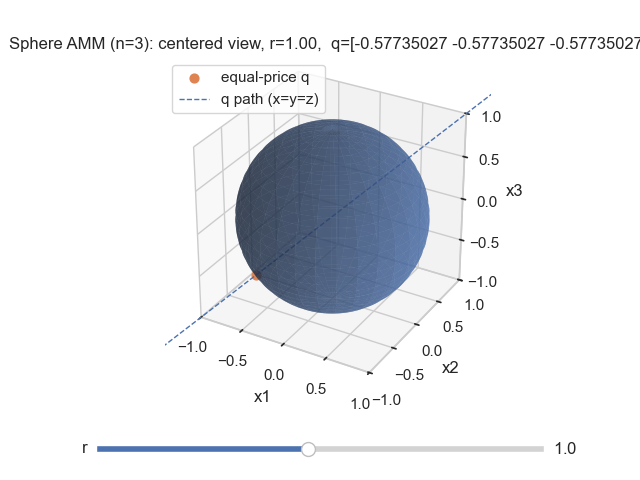

In [6]:
n = 3
amm = SphereAMM(n, r0)

u = np.linspace(0, np.pi, 120)
v = np.linspace(0, 2*np.pi, 120)
su, sv = np.meshgrid(u, v, indexing="ij")

def sphere_xyz_centered(r):
    X = r * np.sin(su) * np.cos(sv)
    Y = r * np.sin(su) * np.sin(sv)
    Z = r * np.cos(su)
    return X, Y, Z

def q_centered(r):
    offset = - r / np.sqrt(n)
    return np.array([offset, offset, offset])

X, Y, Z = sphere_xyz_centered(r0)
qc = q_centered(r0)

fig = plt.figure()
plt.subplots_adjust(bottom=0.2)
ax = fig.add_subplot(111, projection='3d')

surf  = ax.plot_surface(X, Y, Z, rstride=4, cstride=4, linewidth=0, alpha=0.6, color="C0")
point = ax.scatter([qc[0]], [qc[1]], [qc[2]], s=40, color="C1", label="equal-price q")

L = 5.0
(path_line,) = ax.plot([-L, L], [-L, L], [-L, L], linestyle='--', linewidth=1.0, label="q path (x=y=z)")

ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.set_zlabel("x3")
ax.set_title(f"Sphere AMM (n={n}): centered view, r={r0:.2f},  q={qc}")
ax.set_box_aspect([1,1,1])
ax.legend(loc="best")

ax.set_xlim(-1.0, 1.0); ax.set_ylim(-1.0, 1.0); ax.set_zlim(-1.0, 1.0)
ax.set_autoscale_on(False)

ax_r = plt.axes([0.15, 0.05, 0.7, 0.03])
s_r = Slider(ax=ax_r, label="r", valmin=0.1, valmax=2.0, valinit=r0, valstep=0.01)

state = {"surf": surf, "point": point}

def update(val):
    r = s_r.val
    amm.r = r

    state["surf"].remove()
    X, Y, Z = sphere_xyz_centered(r)
    state["surf"] = ax.plot_surface(X, Y, Z, rstride=4, cstride=4, linewidth=0, alpha=0.6, color="C0")

    state["point"].remove()
    qc = q_centered(r)
    state["point"] = ax.scatter([qc[0]], [qc[1]], [qc[2]], s=40, color="C1", label="equal-price q")

    ax.set_xlim(-1.0, 1.0); ax.set_ylim(-1.0, 1.0); ax.set_zlim(-1.0, 1.0)
    ax.set_title(f"Sphere AMM (n={n}): centered view, r={r:.2f}, q={qc}")
    fig.canvas.draw_idle()

s_r.on_changed(update)
plt.show()


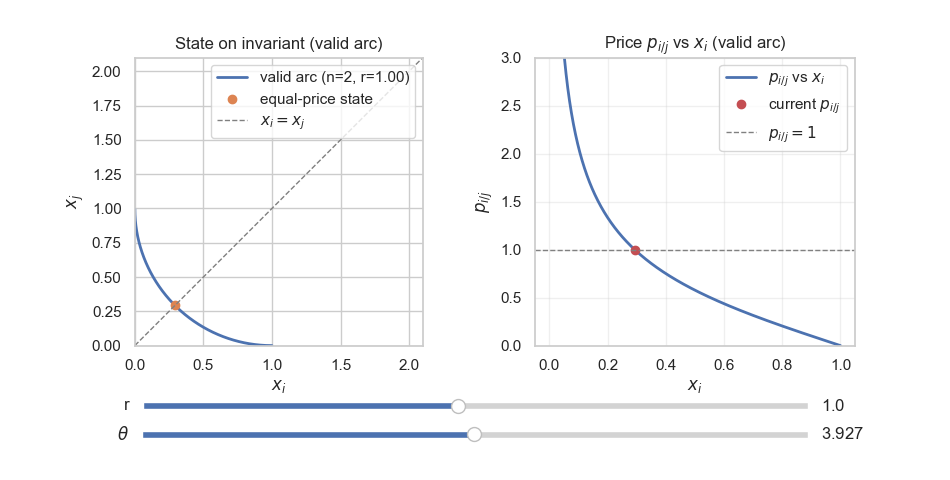

In [7]:
n = 2
amm = SphereAMM(n, r0)

eps = 5e-3
TH_MIN, TH_MAX = np.pi + eps, 1.5*np.pi
T = np.linspace(TH_MIN, TH_MAX, 900)
TH_EQ = 5*np.pi/4  

def arc_states(amm, thetas):
    X = np.array([amm.state_on_circle(th) for th in thetas])  
    return X[:,0], X[:,1]

def prices_on_arc(amm, thetas):
    return np.array([amm.price_ij(amm.state_on_circle(th), 0, 1) for th in thetas])

Xi, Xj = arc_states(amm, T)
P      = prices_on_arc(amm, T)
x_now  = amm.state_on_circle(TH_EQ)
p_now  = amm.price_ij(x_now, 0, 1)

fig, (axL, axR) = plt.subplots(1, 2, figsize=(9.5, 4.8))
plt.subplots_adjust(bottom=0.28, wspace=0.3)

line_arc, = axL.plot(Xi, Xj, lw=2, label=f"valid arc (n={n}, r={r0:.2f})")
ptL, = axL.plot([x_now[0]], [x_now[1]], 'o', label="equal-price state")
axL.axline((0,0), slope=1, linestyle='--', linewidth=1.0, color='gray', label=r'$x_i=x_j$')
axL.set_aspect('equal', 'box')
axL.set_xlabel(r'$x_i$'); axL.set_ylabel(r'$x_j$')
axL.set_title('State on invariant (valid arc)')
axL.set_xlim(0, 2.1*r0); axL.set_ylim(0, 2.1*r0)
axL.legend(loc='best')

line_price, = axR.plot(Xi, P, lw=2, label=r"$p_{i/j}$ vs $x_i$")
mrkR, = axR.plot([x_now[0]], [p_now], 'ro', label=r"current $p_{i/j}$")
axR.axhline(1.0, linestyle='--', linewidth=1.0, color='gray', label=r'$p_{i/j}=1$')
axR.set_xlabel(r'$x_i$'); axR.set_ylabel(r'$p_{i/j}$')
axR.set_title(r'Price $p_{i/j}$ vs $x_i$ (valid arc)')
axR.grid(True, alpha=0.3)
axR.set_ylim(0.0, 3.0) 
axR.legend(loc='best')

ax_r = plt.axes([0.15, 0.14, 0.7, 0.03])
ax_th = plt.axes([0.15, 0.08, 0.7, 0.03])
s_r = Slider(ax=ax_r,  label='r', valmin=0.1, valmax=2.0, valinit=r0,  valstep=0.005)
s_th = Slider(ax=ax_th, label=r'$\theta$', valmin=TH_MIN, valmax=TH_MAX, valinit=TH_EQ)

def update(_):
    amm.r = s_r.val
    theta = s_th.val

    Xi, Xj = arc_states(amm, T)
    P = prices_on_arc(amm, T)

    line_arc.set_data(Xi, Xj)
    line_arc.set_label(f"valid arc (n={n}, r={amm.r:.2f})")

    x_now = amm.state_on_circle(theta)
    p_now = amm.price_ij(x_now, 0, 1)
    ptL.set_data([x_now[0]], [x_now[1]])
    line_price.set_data(Xi, P)
    mrkR.set_data([x_now[0]], [p_now])

    axR.set_ylim(0.0, 3.0)

    fig.canvas.draw_idle()

s_r.on_changed(update); s_th.on_changed(update)
plt.show()
